### Necessary imports

In [23]:
import torch
from torch import nn
from torch import optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Load Pictures

In [24]:
# data path
data_dir = 'flowers'
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.2

# Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()]) 

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()])


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

### Show some simples from data

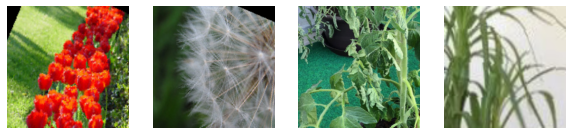

In [25]:
# Run this to test your data loader
import helper
data_iter = iter(train_loader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii], ax=ax, normalize=False)

### Download And Show pretrained model 

In [26]:
model = models.densenet121(pretrained=True)
# model

### Freeze pretrainid models Prametere

In [27]:
for param in model.parameters():
    param.requires_grad = False

### Change Classifier Of Pretrained Model For our Project

### Use a pretrained model to classify the flower images

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device);

### Run Model

In [29]:
epochs = 10
steps = 0
running_loss = 0
print_every = 1

valid_loss_average_min = np.Inf

for epoch in range(epochs):    
    valid_loss_average = 0.0 
    for inputs, labels in train_loader:
        steps += 1        
        inputs, labels = inputs.to(device), labels.to(device)        
        optimizer.zero_grad()        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()        
        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            model.eval()            
            with torch.no_grad():
                for inputs, labels in valid_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)                    
                    valid_loss += batch_loss.item()                   
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item() 
            valid_loss_average = valid_loss/len(valid_loader)
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Valid loss: {valid_loss_average:.3f}.. "
                  f"Valid accuracy: {accuracy/len(valid_loader):.3f}")
            running_loss = 0
            model.train()
    if valid_loss_average < valid_loss_average_min:
        print('Valid loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
              .format(valid_loss_average_min, valid_loss_average))
        torch.save(model.state_dict(), 'transferlearning_model_equal.pt')
        valid_loss_average_min = valid_loss_average
 



Epoch 1/10.. Train loss: 0.652.. Valid loss: 1.106.. Valid accuracy: 0.478
Epoch 1/10.. Train loss: 1.351.. Valid loss: 1.063.. Valid accuracy: 0.522
Epoch 1/10.. Train loss: 1.422.. Valid loss: 0.795.. Valid accuracy: 0.522
Valid loss decreased (inf --> 0.795271).  Saving model ...
Epoch 2/10.. Train loss: 0.833.. Valid loss: 0.615.. Valid accuracy: 0.652
Epoch 2/10.. Train loss: 0.608.. Valid loss: 0.819.. Valid accuracy: 0.565
Epoch 2/10.. Train loss: 0.754.. Valid loss: 0.797.. Valid accuracy: 0.522
Epoch 3/10.. Train loss: 0.680.. Valid loss: 0.607.. Valid accuracy: 0.652
Epoch 3/10.. Train loss: 0.577.. Valid loss: 0.581.. Valid accuracy: 0.652
Epoch 3/10.. Train loss: 0.556.. Valid loss: 0.611.. Valid accuracy: 0.652
Valid loss decreased (0.795271 --> 0.610651).  Saving model ...
Epoch 4/10.. Train loss: 0.637.. Valid loss: 0.614.. Valid accuracy: 0.565
Epoch 4/10.. Train loss: 0.440.. Valid loss: 0.592.. Valid accuracy: 0.609
Epoch 4/10.. Train loss: 0.541.. Valid loss: 0.630..

In [30]:
model.load_state_dict(torch.load('transferlearning_model_equal.pt'))

<All keys matched successfully>

In [31]:
# specify the image classes
classes = ['good', 'thirsty']

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    inputs, labels = inputs.to(device), labels.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if device == "cpu" else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(data.size(0)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.362567

Test Accuracy of  good: 73% (22/30)
Test Accuracy of thirsty: 100% (24/24)

Test Accuracy (Overall): 85% (46/54)
